In [78]:
import torch
from torch import nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt

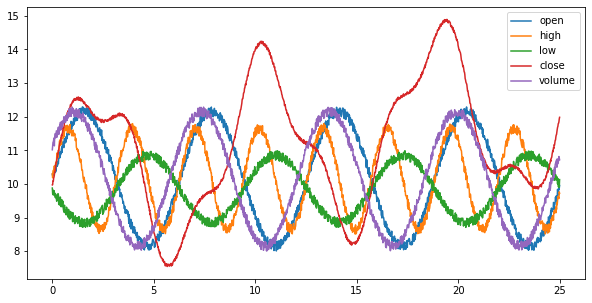

In [79]:
t = torch.linspace(0, 25, 1500)
open = 10 + 2 * torch.sin(t) + 0.3 * torch.rand(t.shape)
high = 10 + 1.5 * torch.sin(2 * t) + 0.3 * torch.rand(t.shape)
low = 10 + torch.sin(-t) - 0.3 * torch.rand(t.shape)
close = 10 + 2.5 * torch.sin(0.75 * t) + 0.75 * torch.sin(2 * t) + 0.1 * t - 0.1 * torch.rand(t.shape)
volume = 10 + 2 * torch.sin(t + 0.5) + 0.3 * torch.rand(t.shape)

plt.figure(figsize=(10, 5))
plt.plot(t, open, label='open')
plt.plot(t, high, label='high')
plt.plot(t, low, label='low')
plt.plot(t, close, label='close')
plt.plot(t, volume, label='volume')
plt.legend();
# will be attempting to predict the change in close price

In [80]:
X = torch.stack([open, high, low, close, volume], dim=1)
X.shape

torch.Size([1500, 5])

In [81]:
y = torch.tensor([(b - a) / a for a, b in zip(close[:-1], close[1:])])
y.shape

torch.Size([1499])

In [82]:
# need to drop the very first value of X and t
X = X[1:]
t = t[1:]

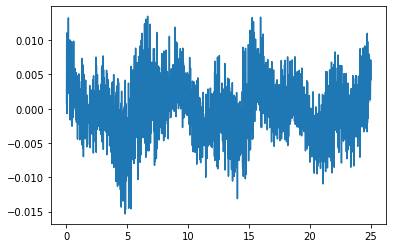

In [83]:
plt.plot(t, y);

In [84]:
train_split = int(0.8 * len(X))
test_split = int(0.9 * len(X))

X_train, X_test, X_val = X[:train_split], X[train_split:test_split], X[test_split:]
y_train, y_test, y_val = y[:train_split], y[train_split:test_split], y[test_split:]

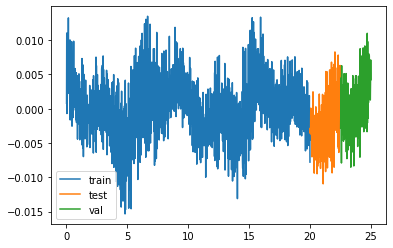

In [85]:
plt.plot(t[:train_split], y_train, label='train')
plt.plot(t[train_split:test_split], y_test, label='test')
plt.plot(t[test_split:], y_val, label='val')
plt.legend();
# here are our splits and what we are trying to predict

In [86]:
# this is just a toy model and the only thing that affects the target is the close price
# the hope being that the model will realise this and learn to predict the change in close price

In [98]:
## Model parameters
dim_val = 512 # This can be any value divisible by n_heads. 512 is used in the original transformer paper.
n_heads = 8 # The number of attention heads (aka parallel attention layers). dim_val must be divisible by this number
n_decoder_layers = 4 # Number of times the decoder layer is stacked in the decoder
n_encoder_layers = 4 # Number of times the encoder layer is stacked in the encoder
input_size = 5 # The number of input variables. 1 if univariate forecasting.
dec_seq_len = 92 # length of input given to decoder. Can have any integer value.
enc_seq_len = 128 # length of input given to encoder. Can have any integer value.
output_sequence_length = 3 # Length of the target sequence, i.e. how many time steps should your forecast cover
max_seq_len = enc_seq_len # What's the longest sequence the model will encounter? Used to make the positional encoder

In [93]:
# input_shape = (32, 128, 5) - batch_size, sequence_length, features

In [94]:
# we begin by teaching the model what time means
# this will be doen with a time embedding layer following the Time2Vec paper

class Time2Vec(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.seq_len = seq_len
        self.linear_time = nn.Linear(seq_len, seq_len)
        self.periodic_time = nn.Linear(seq_len, seq_len)

    def forward(self, x):
        x = x[:, :, 3].view(-1, self.seq_len) # use only the close price for this one
        linear_time = self.linear_time(x).view(-1, self.seq_len, 1)        
        periodic_time = torch.sin(self.periodic_time(x)).view(-1, self.seq_len, 1)
        return torch.cat([linear_time, periodic_time], dim=-1)     

In [95]:
test_batch = torch.rand(32, 128, 5)
m = Time2Vec(128)
m(test_batch).shape

torch.Size([32, 128, 2])

In [96]:
# alternatively we could use a positional encoding layer like in the original transformer paper

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000, batch_first=False):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        self.batch_first = batch_first
        self.x_dim = 1 if batch_first else 0

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)

        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

        

    def forward(self, x):
        x = x + self.pe[:x.size(self.x_dim)]
        return self.dropout(x)

In [97]:
test_batch = torch.rand(32, 128, 5)
m = PositionalEncoding(dim_val)
m(test_batch).shape

RuntimeError: The size of tensor a (5) must match the size of tensor b (512) at non-singleton dimension 2